In [4]:
import pandas as pd
import scipy.io as sio
import numpy as np
from matplotlib import pyplot as plt
import seaborn
from IPython.core.display import display
import glob
from scipy.sparse import csr_matrix

%matplotlib inline

In [10]:
#df = pd.read_pickle('../testData/scrobbles_processed/5759068.pkl') # ME!
coords = np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output_normed',delimiter='\t')

# global viz

In [84]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

sp = load_sparse_csr('../testData/global_traj_sparse.npz')

In [85]:
## https://stackoverflow.com/questions/13079563/how-does-condensed-distance-matrix-work-pdist

"""
full matrix index -> condensed index
"""

def choose2(n):
    return n * (n-1) / 2

n=112312
n_choose_2 = choose2(n)

def get_idx(i,j):
    if i>j:
        j,i = i,j
    return n_choose_2 - choose2(n-i) + (j-i-1)

"""
condensed index -> full matrix index
"""

import math

def calc_row_idx(k, n):
    return int(math.ceil((1/2.) * (- (-8*k + 4 *n**2 -4*n - 7)**0.5 + 2*n -1) - 1))

def elem_in_i_rows(i, n):
    return i * (n - 1 - i) + (i*(i + 1))/2

def calc_col_idx(k, i, n):
    return int(n - elem_in_i_rows(i + 1, n) + k)

def condensed_to_square(k, n):
    i = calc_row_idx(k, n)
    j = calc_col_idx(k, i, n)
    return i, j


In [86]:
coord_data = pd.DataFrame(coords)
coord_data.columns = ['x','y']
df = {'artist_a':[],'artist_b':[],'weight':[]}
for idx,val in zip(sp.indices,sp.data):
    i,j = condensed_to_square(idx,n)
    df['artist_a'].append(i)
    df['artist_b'].append(j)
    df['weight'].append(val)
df = pd.DataFrame(df)   

In [87]:
joined = df.join(coord_data,on='artist_a').join(coord_data,on='artist_b',rsuffix='_b')
joined = joined[joined['weight']>=1000]
joined['weight'] = joined['weight']/joined['weight'].max()
joined.head()

,artist_a,artist_b,weight,x,y,x_b,y_b
0,0,1,0.686636,3.517573,1.026396,4.541131,-1.237661
1,0,2,0.356193,3.517573,1.026396,3.803132,1.026524
2,0,3,0.761750,3.517573,1.026396,-13.909371,6.968683
3,0,4,0.267788,3.517573,1.026396,-11.492089,7.007414
4,0,5,0.413110,3.517573,1.026396,-3.743013,6.769641


In [88]:
joined.shape

(67863, 7)

In [89]:
offset = 32
scale = 100
for col in ['x','y','x_b','y_b']:
    joined[col] = joined[col] + offset

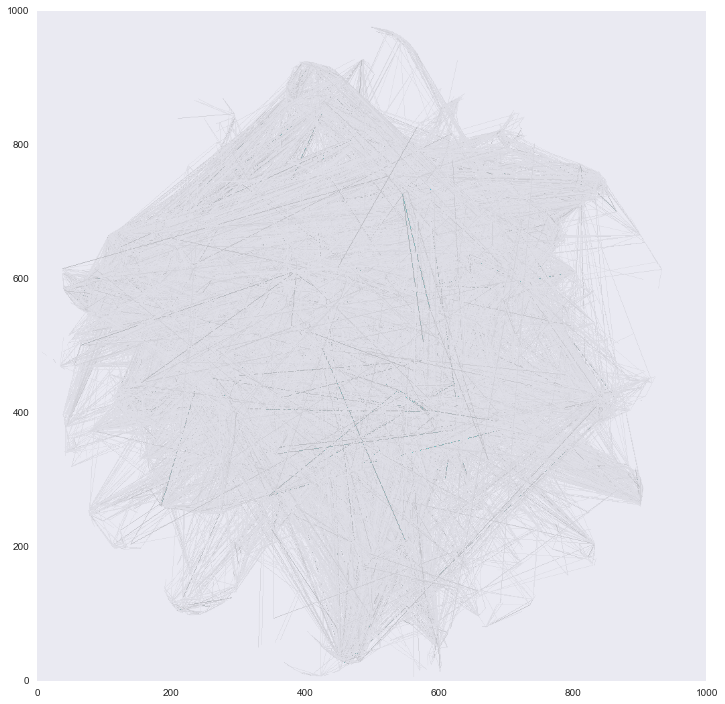

In [90]:
from PIL import Image
from PIL import ImageDraw
import random as rnd
import numpy as np
import matplotlib.pyplot as plt

scale = 15

s = (1000, 1000)
im = Image.new('RGBA', s,)#(255,255,255,255))
draw = ImageDraw.Draw(im)

for i,row in enumerate(joined.iterrows()):
    row = row[1]
    x1 = row['x'] * scale
    y1 = row['y'] * scale
    x2 = row['x_b'] * scale
    y2 = row['y_b'] * scale
    alpha = min(1.,5*row['weight'])
    color  = (59,185,227, int(alpha * 256)) 
    draw.line(((x1,y1),(x2,y2)), fill=color, width=1)

fix,ax = plt.subplots(1,1,figsize=(12,12))
ax.imshow(np.asarray(im),
           origin='lower');
ax.grid()

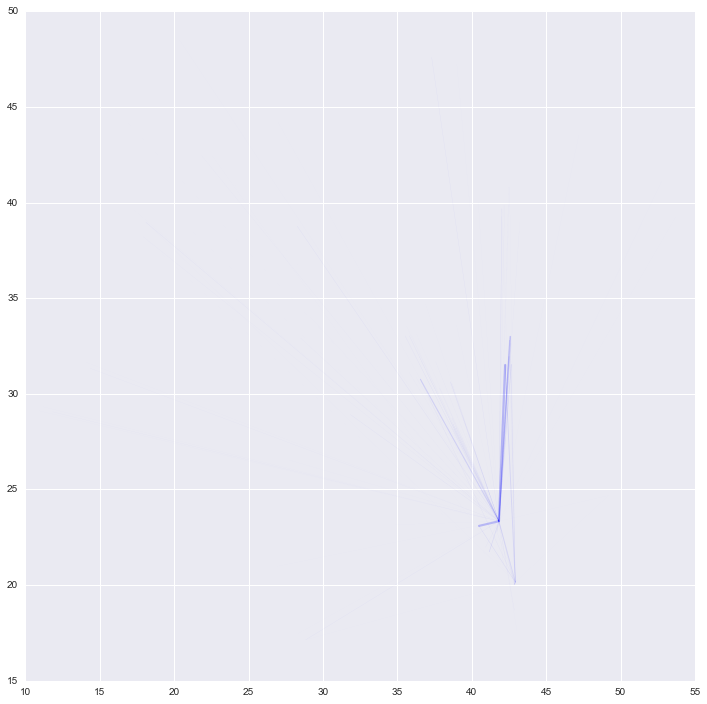

In [83]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
df_l = len(joined)
for i,row in enumerate(joined[joined['artist_a'].isin([711,154])|joined['artist_b'].isin([711,154])].iterrows()):
    row = row[1]
    ax.plot([row['x'],row['x_b']],[row['y'],row['y_b']],c='blue',alpha=row['weight'],lw=row['weight']*10)


In [41]:
def srter(row):
    a,b = row['prev'],row['artist_idx'],
    if b<a:
        a = row['artist_idx']
        b = row['prev']
    return pd.Series({'a':a,'b':b})
df['prev'] = df['artist_idx'].shift(1)
df = pd.concat([df,df.apply(srter,axis=1)],axis=1)          
jumps = df.groupby(['a','b']).count()['block'].reset_index()
coords = pd.DataFrame(Y3).reindex(range(112312))
jumps = jumps.join(coords,on='a').join(coords,on='b',rsuffix='_prev')
jumps[jumps['a']!=jumps['b']]['block'].describe()


count    15328.000000
mean         1.513961
std          1.643726
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
Name: block, dtype: float64

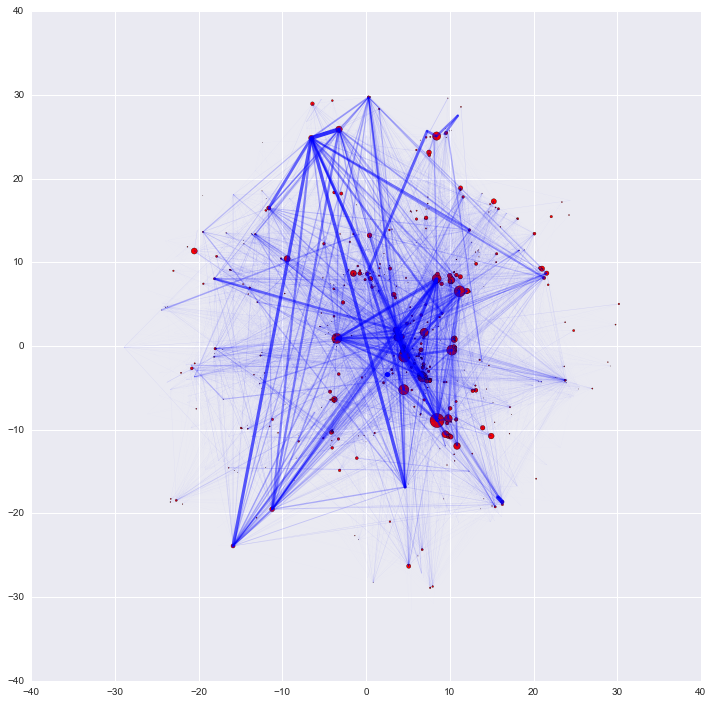

In [42]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
mx = jumps[jumps['a']!=jumps['b']]['block'].max()
for row in jumps.dropna().sort_values(by='block').iterrows():
    row = row[1]
    ax.plot([row['0_prev'],row['0']],[row['1_prev'],row['1']],c='blue',alpha=row['block']/float(mx),lw=5*(row['block']/float(mx)))
self_jumps = jumps[jumps['a']==jumps['b']]
self_jump_mx = self_jumps['block'].max()
ax.scatter(x=self_jumps['0'],y=self_jumps['1'],s=200*(self_jumps['block']/self_jump_mx),c='red')

# ax.set_xlim(-150,150);
# ax.set_ylim(-150,150);
#fig.savefig('/Users/jaredlorince/Desktop/test.pdf')

In [2]:
def srter(row):
    a,b = row['prev'],row['artist_idx'],
    if b<a:
        a = row['artist_idx']
        b = row['prev']
    return pd.Series({'a':a,'b':b})

for f in glob.glob('../testData/scrobbles_processed/*.pkl')[:5]:
    df = pd.read_pickle(f) 

    df['prev'] = df['artist_idx'].shift(1)
    df = pd.concat([df,df.apply(srter,axis=1)],axis=1)          
    jumps = df.groupby(['a','b']).count()['block'].reset_index()
    coords = pd.DataFrame(Y3).reindex(range(112312))
    jumps = jumps.join(coords,on='a').join(coords,on='b',rsuffix='_prev')
    jumps[jumps['a']!=jumps['b']]['block'].describe()
    
    fig,ax = plt.subplots(1,1,figsize=(12,12))
    mx = jumps[jumps['a']!=jumps['b']]['block'].max()
    for row in jumps.dropna().sort_values(by='block').iterrows():
        row = row[1]
        ax.plot([row['0_prev'],row['0']],[row['1_prev'],row['1']],c='blue',alpha=row['block']/float(mx),lw=5*(row['block']/float(mx)))
    self_jumps = jumps[jumps['a']==jumps['b']]
    self_jump_mx = self_jumps['block'].max()
    ax.scatter(x=self_jumps['0'],y=self_jumps['1'],s=200*(self_jumps['block']/self_jump_mx),c='red')
    #ax.grid()
    ax.set_xlim(-35,35)
    ax.set_ylim(-35,35)


NameError: name 'Y3' is not defined